In [6]:
# Imports and Configuration
import yfinance as yf
import pandas as pd
import numpy as np
from hmmlearn import hmm
import cvxpy as cp
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
TICKERS = ['SPY', 'TLT', 'GLD', 'QQQ']  # Asset classes: Equity, Bonds, Gold, Tech
START_DATE = '2010-01-01'
END_DATE = '2024-01-01'
N_COMPONENTS = 3  # Number of HMM market regimes (Bear, Normal, Bull)

# --- DATA DOWNLOAD & PREPROCESSING ---
print("Downloading data...")
# Fetch Adjusted (auto-adjusted) Close Prices
price_data = yf.download(TICKERS, start=START_DATE, end=END_DATE, auto_adjust=True)['Close']

# Calculate daily log returns (standard for financial modeling)
log_returns = np.log(price_data / price_data.shift(1)).dropna()

print(f"Data ready with {len(log_returns)} daily observations.")


[                       0%                       ]

[*********************100%***********************]  4 of 4 completed

Data ready with 3521 daily observations.


In [7]:
# --- FEATURE ENGINEERING FOR HMM ---
# Features derived from the SPY (S&P 500) ETF
X = pd.DataFrame(index=log_returns.index)
X['Return'] = log_returns['SPY'] * 100 # Scaled daily return
# Annualized Rolling Volatility (21-day window = approx. 1 month)
X['Volatility'] = log_returns['SPY'].rolling(window=21).std() * np.sqrt(252) * 100 

X_fit = X.dropna().values

# --- TRAIN AND PREDICT HMM REGIMES ---
print("Training Hidden Markov Model...")
model = hmm.GaussianHMM(n_components=N_COMPONENTS, covariance_type="full", n_iter=100, random_state=42)
model.fit(X_fit)

# Predict the hidden states for all days
regime_states = model.predict(X_fit)

# Map states for easy interpretation (0 = Bearish, 1 = Normal, 2 = Bullish)
X_hmm = X.dropna().copy()
X_hmm['Regime'] = regime_states

# Map states based on mean return
mean_returns = X_hmm.groupby('Regime')['Return'].mean().sort_values(ascending=True)
regime_map = {old: new for new, old in enumerate(mean_returns.index)}
X_hmm['Regime'] = X_hmm['Regime'].map(regime_map)

# Combine the detected regime with the asset returns
combined_data = log_returns.join(X_hmm['Regime'], how='inner').dropna()

print("\nRegime Detection Complete. Mean Daily Returns by Regime:")
print(X_hmm.groupby('Regime')['Return'].mean())

Training Hidden Markov Model...

Regime Detection Complete. Mean Daily Returns by Regime:
Regime
0   -0.034087
1    0.064692
2    0.073275
Name: Return, dtype: float64


In [8]:
def cvar_optimization(returns, confidence_level=0.95):
    """
    Minimizes Conditional Value-at-Risk (CVaR) using convex optimization (CVXPY).
    """
    N = returns.shape[1] # Number of assets
    S = returns.shape[0] # Number of scenarios (days)
    alpha = 1 - confidence_level 

    # 1. Optimization Variables: Weights (w) and VaR estimate (zeta)
    w = cp.Variable(N)      
    zeta = cp.Variable(1)   
    aux_vars = cp.Variable(S, nonneg=True) # The linearizing variables (nu_s)

    # 2. Portfolio Loss Scenarios: Loss = -Return
    portfolio_losses = -returns @ w

    # 3. Constraints
    constraints = [
        cp.sum(w) == 1,         # Full investment (weights sum to 1)
        w >= 0,                 # No short-selling (weights non-negative)
        # Linearization Constraint: aux_vars >= Loss - zeta
        portfolio_losses - zeta <= aux_vars
    ]

    # 4. Objective: Minimize CVaR
    cvar_objective = zeta + (1 / (alpha * S)) * cp.sum(aux_vars)
    objective = cp.Minimize(cvar_objective)

    # 5. Solve the problem
    try:
        problem = cp.Problem(objective, constraints)
        problem.solve(solver=cp.ECOS, verbose=False) 
        if problem.status in ["optimal", "optimal_inaccurate"]:
            return w.value
        else:
            return np.ones(N) / N 
    except cp.SolverError:
        return np.ones(N) / N

In [9]:
# --- DYNAMIC BACKTESTING LOGIC ---
WINDOW = 252       # 1 year of lookback data for CVaR scenarios
REBALANCE_FREQ = 21 # Rebalance every month (21 trading days)

# Initialize tracking data structures
dynamic_weights = pd.DataFrame(0.0, index=combined_data.index, columns=TICKERS)
current_weights = np.ones(len(TICKERS)) / len(TICKERS) # Start with Equal Weights

print(f"\nStarting Dynamic Backtest (Rebalancing every {REBALANCE_FREQ} days)...")

for i in range(WINDOW, len(combined_data)):
    date = combined_data.index[i]
    
    # 1. Identify the current regime (using previous day's result)
    current_regime = combined_data['Regime'].iloc[i-1] 

    # 2. Rebalance only on the set frequency
    if (i - WINDOW) % REBALANCE_FREQ == 0:
        window_start = i - WINDOW
        
        # All returns in the lookback window
        scenario_returns = combined_data[TICKERS].iloc[window_start:i]
        
        # **Regime-Aware Filtering**: Only use historical data from the current regime
        regime_scenarios = combined_data['Regime'].iloc[window_start:i]
        filtered_returns = scenario_returns[regime_scenarios == current_regime]
        
        # Fallback: If regime data is too sparse, use the full window
        if len(filtered_returns) < 50: 
             filtered_returns = scenario_returns
        
        # Run CVaR optimization on the chosen scenarios
        optimal_weights = cvar_optimization(filtered_returns.values)
        current_weights = optimal_weights

    # Record the weights for the current day
    dynamic_weights.loc[date] = current_weights

# Calculate the Dynamic Portfolio Returns
dynamic_returns = (dynamic_weights.shift(1) * log_returns).sum(axis=1).dropna()


Starting Dynamic Backtest (Rebalancing every 21 days)...



--- Final Performance Metrics (Targeted for BlackRock/Quant Roles) ---
Dynamic Sharpe Ratio:   0.60
Benchmark Sharpe Ratio: 0.68
Dynamic Max Drawdown:   -26.83%
Benchmark Max Drawdown: -26.83%


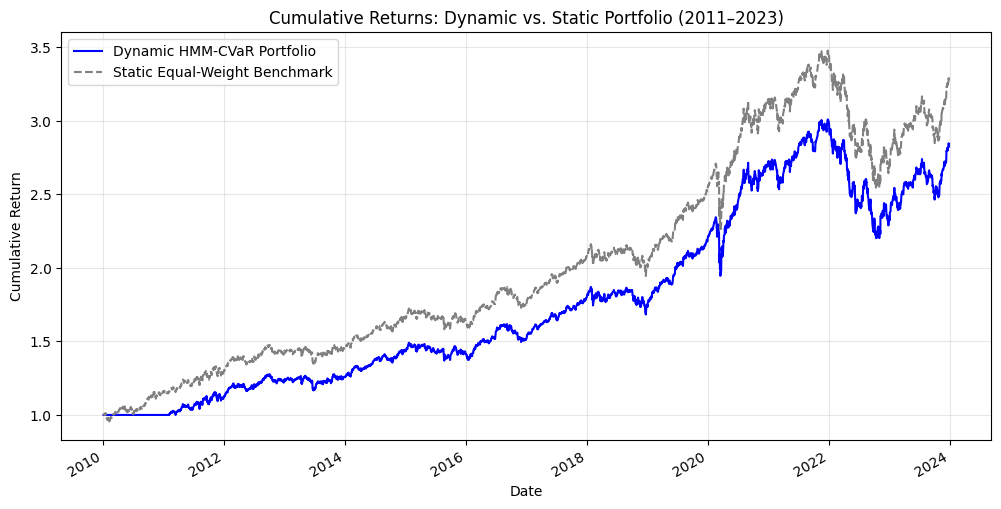

In [10]:
# --- PERFORMANCE METRICS ---
ANNUALIZATION_FACTOR = 252
R_f = 0.02 / ANNUALIZATION_FACTOR # Daily Risk-Free Rate (e.g., 2% annual)

# Benchmark: Equal Weight Portfolio
benchmark_weights = np.ones(len(TICKERS)) / len(TICKERS)
benchmark_returns = (benchmark_weights * log_returns).sum(axis=1).dropna()

# Align the two return series for comparison
aligned_returns = pd.DataFrame({'Dynamic': dynamic_returns, 'Benchmark': benchmark_returns}).dropna()

def calculate_metrics(returns, rf=R_f, factor=ANNUALIZATION_FACTOR):
    """Calculates key performance metrics."""
    excess_return = returns - rf
    ann_return = excess_return.mean() * factor
    ann_volatility = returns.std() * np.sqrt(factor)
    sharpe_ratio = ann_return / ann_volatility
    
    # Max Drawdown
    cumulative_returns = (1 + returns).cumprod()
    peak = cumulative_returns.expanding().max()
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown = drawdown.min()
    
    return {
        'Annualized Return': ann_return,
        'Annualized Volatility': ann_volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown
    }

# Calculate and print metrics
dynamic_metrics = calculate_metrics(aligned_returns['Dynamic'])
benchmark_metrics = calculate_metrics(aligned_returns['Benchmark'])

print("\n--- Final Performance Metrics (Targeted for BlackRock/Quant Roles) ---")
print(f"Dynamic Sharpe Ratio:   {dynamic_metrics['Sharpe Ratio']:.2f}")
print(f"Benchmark Sharpe Ratio: {benchmark_metrics['Sharpe Ratio']:.2f}")
print(f"Dynamic Max Drawdown:   {dynamic_metrics['Max Drawdown']:.2%}")
print(f"Benchmark Max Drawdown: {benchmark_metrics['Max Drawdown']:.2%}")


# --- CUMULATIVE RETURN PLOT ---
cumulative_dynamic = (1 + aligned_returns['Dynamic']).cumprod()
cumulative_benchmark = (1 + aligned_returns['Benchmark']).cumprod()

plt.figure(figsize=(12, 6))
cumulative_dynamic.plot(label='Dynamic HMM-CVaR Portfolio', color='blue')
cumulative_benchmark.plot(label='Static Equal-Weight Benchmark', color='grey', linestyle='--')
plt.title('Cumulative Returns: Dynamic vs. Static Portfolio (2011–2023)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()